In [2]:
import pandas as pd
import numpy as np
import seaborn as sb
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error, median_absolute_error, mean_absolute_percentage_error
from sklearn.model_selection import train_test_split
from tabulate import tabulate


In [3]:
## starter code from jason
dat = pd.read_csv('insurance.csv')
dat['smoker'] =dat.smoker.map({'yes':1, 'no':0})

one_hot_region = pd.get_dummies(dat.region, prefix='region')
dat['region_northeast']= one_hot_region['region_northeast']
dat['region_northwest']= one_hot_region['region_northwest']
dat['region_southeast']= one_hot_region['region_southeast']
dat['region_southwest']= one_hot_region['region_southwest']
one_hot_sex = pd.get_dummies(dat.sex, prefix='sex')
dat['female']= one_hot_sex['sex_female']
dat['male']= one_hot_sex['sex_male']

dat_dropped = dat.drop(columns = ['sex', 'region'])

cols = dat_dropped.columns.tolist()
cols = [cols[0]] + cols[-2:] + cols[1:4] + cols[5:9] + [cols[4]]
dat_dropped = dat_dropped[cols]
#dat_dropped.head()

dat_dropped.to_csv('one_hot_insurance.csv')
ohdat = pd.read_csv('one_hot_insurance.csv')
ohdat = ohdat.iloc[:,1:]
ohdat.head()

,age,female,male,bmi,children,smoker,region_northeast,region_northwest,region_southeast,region_southwest,charges
0,19,1,0,27.900,0,1,0,0,0,1,16884.92400
1,18,0,1,33.770,1,0,0,0,1,0,1725.55230
2,28,0,1,33.000,3,0,0,0,1,0,4449.46200
3,33,0,1,22.705,0,0,0,1,0,0,21984.47061
4,32,0,1,28.880,0,0,0,1,0,0,3866.85520


### Creating a Function To Run Regression Models

In the cell below, I created a function that can run a handful of Regression Models, such as Decison Tree, Lasso, Random Forest, and more. This made it easier to analyze the resutls, rather than ahving to copy and past the code to run differnet models. Now we can just pass an import below and get our results!

In [4]:
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import Lasso
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.linear_model import Ridge
from sklearn.tree import DecisionTreeRegressor, plot_tree

In [14]:
def insurance_reg(factor, target, data):
    x_train, X_test, y_train, y_test = train_test_split(data[factor], data[target], test_size = 0.25, random_state = 10)
    mod = GradientBoostingRegressor(random_state=25) #try the regression models imported above
    mod.fit(x_train, y_train)
    y_pred = mod.predict(X_test)
    residuals = y_test - y_pred
    
    R2 = r2_score(y_test, y_pred)
    MSE = mean_squared_error(y_test, y_pred)
    MAE = mean_absolute_error(y_test, y_pred)
    MedAE = median_absolute_error(y_test, y_pred)
    
    return R2, MSE, MAE, MedAE

factor_combos = [
    (['smoker'], 'charges'),
     (['region_northeast', 'region_northwest', 'region_southeast', 'region_southwest'], 'charges'),
    (['smoker', 'age', 'bmi'], 'charges'),
    (['children'], 'charges'),
    (['male', 'female'], 'charges'),
   ] #can add as many combinations to test against charges

for i in factor_combos:
    factor, target = i
    R2,MSE,MAE,MedAE = insurance_reg(factor, target, dat_dropped)
    
    print(f"Features: {', '.join(factor)}")
    print(f"Target: {target}")
    print('~ R2:', R2)
    print('~ MSE:', MSE)
    print('~ Mean Absolute Error:', MAE)
    print('~ Median Absolute Error:', MedAE)
    print("")

Features: smoker
Target: charges
~ R2: 0.616255352899973
~ MSE: 51599902.20038582
~ Mean Absolute Error: 5481.905331873467
~ Median Absolute Error: 4179.271903328814

Features: region_northeast, region_northwest, region_southeast, region_southwest
Target: charges
~ R2: -0.01639925357790828
~ MSE: 136669273.37619543
~ Mean Absolute Error: 8827.863570779098
~ Median Absolute Error: 7135.336139358467

Features: smoker, age, bmi
Target: charges
~ R2: 0.8378676222694041
~ MSE: 21800994.222687025
~ Mean Absolute Error: 2574.9752550184016
~ Median Absolute Error: 1339.6404603461524

Features: children
Target: charges
~ R2: 0.010833342999202134
~ MSE: 133007465.11213073
~ Mean Absolute Error: 8736.890519694005
~ Median Absolute Error: 7470.398260251305

Features: male, female
Target: charges
~ R2: -0.0008943137797701173
~ MSE: 134584414.64721292
~ Mean Absolute Error: 8788.292546854385
~ Median Absolute Error: 7142.732303840667



### Function Results

With this function, we compare multiple factor combinations using the GradientBoostingRegressor Model in order to predict which factors would be better to use when predicting insurance charges. Here are some important results to take note of:

- **Smoker:**
    - The smoker feature alone yields a moderately good fit, with an R-squared value of 0.6163. However, its errors are higher compared to the combination of smoker, age, and BMI features, telling us that we can better predict insurance charges when additionally taking age and BMI factors into consideration as to the Smoker factor alone.
    

- **Regional Features (Combined)**
    - These features alone do not have a good fit when predicting insurance values, as the R-squared value is -0.0164, showing us that the model does not correlate at all with the charges. The errors (MSE, MAE, and MedAE) are also quite high, which confirms the poor model performance.
    
    
- **Smoker + Age + BMI:**
    - A combination of smoker, age, and BMI features results in the best model performance among the tested combinations. The R-squared value is 0.838 and The errors (MSE, MAE, and MedAE) are much lower compared to other combinations, further supporting that this set of features provides the one of the better predictive performances.
    
   
- **Number Of Children:**
    - The number of children results in a weak predictive model, as the R-squared value is nearly 0 and has pretty high error values.
    
    
- **Male + Female:**
    - Sex also would not provide meaningful predictions, as the R-squared value is negative, meaning that the model doesn't explain the variance in charges and results in high error values.

### Comparing Regions 

In [6]:
region_combos = [
     (['region_northeast'], 'charges'),
     (['region_northwest'], 'charges'),
     (['region_southeast'], 'charges'),
     (['region_southwest'], 'charges')] #can add as many combinations to test against charges

print()
for i in region_combos:
    factor, target = i
    R2,MSE,MAE,MedAE = insurance_reg(factor, target, dat_dropped)
    
    print(f"Features: {', '.join(factor)}")
    print(f"Target: {target}")
    print('~ R2:', R2)
    print('~ MSE:', MSE)
    print('~ Mean Absolute Error:', MAE)
    print('~ Median Absolute Error:', MedAE)
    print("")


Features: region_northeast
Target: charges
~ R2: -0.0017306609663092498
~ MSE: 134696873.37036937
~ Mean Absolute Error: 8758.057163229614
~ Median Absolute Error: 7168.278627412799

Features: region_northwest
Target: charges
~ R2: 0.003229281594591016
~ MSE: 134029938.85285601
~ Mean Absolute Error: 8731.114691823226
~ Median Absolute Error: 7094.009510888649

Features: region_southeast
Target: charges
~ R2: -0.01497176567980052
~ MSE: 136477327.41293252
~ Mean Absolute Error: 8833.713911041226
~ Median Absolute Error: 7191.793924351599

Features: region_southwest
Target: charges
~ R2: -0.010270923274300126
~ MSE: 135845232.58055815
~ Mean Absolute Error: 8788.481733678662
~ Median Absolute Error: 7135.336139358469



- **Regional Features (Seperated):**
    - These features alone do not have a good fit when predicting insurance values, as the R-squared for three out of the four regions have are negative, and the other one is nearly zero, showing us that the model does not correlate at all with the charges. The errors (MSE, MAE, and MedAE) are also quite high, which confirms the poor model performance.
    

### A Few Plot Results

Below,we have a few histogram plots to visualize the residuals and how well the prediction models above perform (from a graphical point of view) 

#### Smoker Plot

   smoker      charges
0       1  16884.92400
1       0   1725.55230
2       0   4449.46200
3       0  21984.47061
4       0   3866.85520


Text(0, 0.5, 'count')

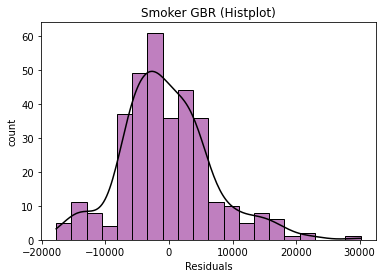

In [11]:
smoker = ohdat.iloc[:,[5,10]]
x_sm_train, x_sm_test, y_sm_train, y_sm_test = train_test_split(smoker.iloc[:,:-1], smoker.iloc[:,-1], test_size = 0.25, random_state = 10)
print(smoker.head())

mod = GradientBoostingRegressor(random_state=0).fit(x_sm_train, y_sm_train)
y_pred = mod.predict(x_sm_test)
residuals = y_sm_test - y_pred

sb.histplot(residuals, kde=True, color="purple")
curve = sb.histplot(kde=True)
curve.lines[0].set_color("black")
plt.title("Smoker GBR (Histplot)")
plt.xlabel('Residuals')
plt.ylabel('count')

We see that the "Smoker" plot has a graph where the residuals are normally distributed around zero, giving us a good resutls. This suggests that the model is making decent predictions, however could be improved by adding other factors, like age and BMI.

#### Smoker + Age + BMI Plot

Text(0, 0.5, 'count')

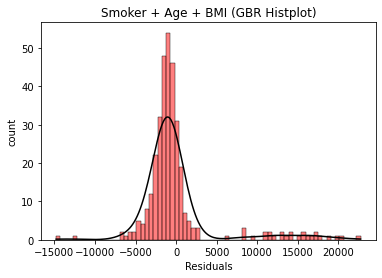

In [10]:
age_bmi_sm = ohdat.iloc[:,[0,3,5,10]]
x_a_b_sm_train, x_a_b_sm_test, y_a_b_sm_train, y_a_b_sm_test = train_test_split(age_bmi_sm.iloc[:,:-1], age_bmi_sm.iloc[:,-1], test_size = 0.25, random_state = 10)
#print(age_bmi_sm.head())

mod = GradientBoostingRegressor(random_state=0).fit(x_a_b_sm_train, y_a_b_sm_train)
y_pred = mod.predict(x_a_b_sm_test)
residuals2 = y_a_b_sm_test - y_pred

sb.histplot(residuals2, kde=True, color="red")
curve2 = sb.histplot(kde=True)
curve2.lines[0].set_color("black")
plt.title("Smoker + Age + BMI (GBR Histplot)")
plt.xlabel('Residuals')
plt.ylabel('count')

We see that the "Smoker + Age + BMI" plot has a graph where the residuals are almost symmetric distribution with a peak near zero, suggesting that the model is making closely accurate predictions.

#### Regions Plot

Text(0, 0.5, 'count')

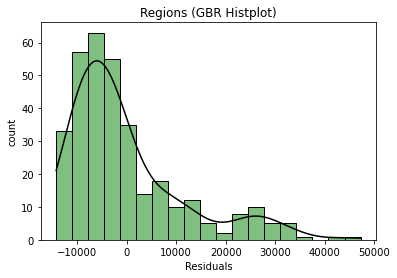

In [12]:
regions_combine = ohdat.iloc[:,[6,7,8,9,10]]
x_region_train, x_region_test, y_region_train, y_region_test = train_test_split(regions_combine.iloc[:,:-1], regions_combine.iloc[:,-1], test_size = 0.25, random_state = 10)
#regions_combine.head()
mod = GradientBoostingRegressor(random_state=0).fit(x_region_train, y_region_train)
y_pred = mod.predict(x_region_test)
residuals3 = y_region_test - y_pred

sb.histplot(residuals3, kde=True, color="green")
curve2 = sb.histplot(kde=True)
curve2.lines[0].set_color("black")
plt.title("Regions (GBR Histplot)")
plt.xlabel('Residuals')
plt.ylabel('count')


We see that the "Regions" plot has a graph where the residuals are uneven and not normally distributed around zero, as we calculed a low R-squared value for the model.